In [1]:
#disk_disk

In [2]:
import numpy as np
import sklearn
import kmapper as km
import pygeodesic
import pygeodesic.geodesic as geodesic
from scipy.spatial import distance_matrix
import vtk
from mpl_toolkits.mplot3d import Axes3D  # noqa
import scipy as sp
import numpy as np
import networkx as nx
import random
import math
from networkx.algorithms import approximation
from scipy.spatial.distance import cdist
import open3d as o3d
import matplotlib
import matplotlib.pyplot as plt

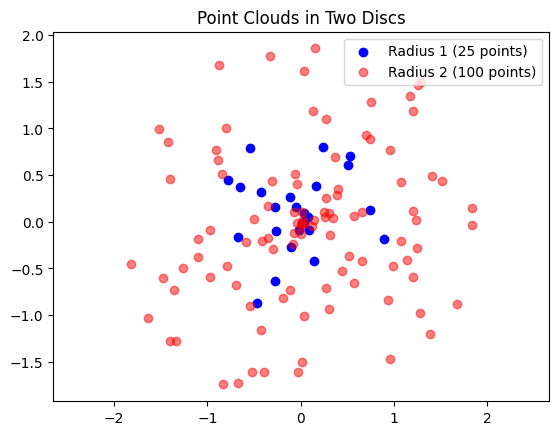

625
10000
1.861844131246017
3.8788118426059315


In [3]:
random_state=1
np.random.seed(random_state)
random.seed(random_state)

def generate_point_cloud(radius, num_points):
    """
    Generate a point cloud within a disc of a given radius.

    :param radius: Radius of the disc.
    :param num_points: Number of points to generate.
    :return: Array of points in the disc.
    """
    # Generate random angles and radii
    angles = np.random.uniform(0, 2 * np.pi, num_points)
    radii = np.random.uniform(0, radius, num_points)

    # Convert polar coordinates to Cartesian coordinates
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)

    return x, y

# Number of points in the larger disc
N = 100

# Generate point clouds for both discs
x_small, y_small = generate_point_cloud(1, N // 4)
x_large, y_large = generate_point_cloud(2, N)

# Plotting
plt.figure()
plt.scatter(x_small, y_small, color='blue', label='Radius 1 (25 points)')
plt.scatter(x_large, y_large, color='red', alpha=0.5, label='Radius 2 (100 points)')
plt.axis('equal')
plt.legend(marksize=3)
plt.title('Point Clouds of Two Disks')
plt.show()


C1 = cdist(np.column_stack((x_small, y_small)), np.column_stack((x_small, y_small)))
C2 = cdist(np.column_stack((x_large, y_large)), np.column_stack((x_large, y_large)))


print(np.size(C1))
print(np.size(C2))

print(np.max(C1))
print(np.max(C2))

np.savetxt(f'DiskDisk_C1_0107.csv', C1, delimiter=',', fmt='%.10f')
np.savetxt(f'DiskDisk_C2_0107.csv', C2, delimiter=',', fmt='%.10f')  


In [4]:
def vertex_with_most_edges(graph):
    degrees = dict(graph.degree())     
    max_degree = max(degrees.values())
    max_degree_vertices = [vertex for vertex, degree in degrees.items() if degree == max_degree]

    return max_degree_vertices, max_degree

In [5]:
def is_vertex_cover(graph, cover):
    """ Check if the set of nodes forms a vertex cover """
    for u, v in graph.edges():
        if u not in cover and v not in cover:
            return False
    return True


In [6]:
def is_minimal_vertex_cover(G, vertex_cover):
        # Check if the set covers all edges
        for u, v in G.edges():
            if u not in vertex_cover and v not in vertex_cover:
                return False  # The set does not cover all edges
        # Check for minimality
        for vertex in vertex_cover:
            # Try removing the vertex and see if it's still a vertex cover
            reduced_cover = vertex_cover - {vertex}
            if all(u in reduced_cover or v in reduced_cover for u, v in G.edges()):
                return False  # Found a smaller vertex cover
        return True  # The vertex cover is minimal

In [7]:
def minimize_vertex_cover(graph, initial_cover):
    """ Minimize the vertex cover """
    minimal_cover = initial_cover.copy()
    removed = True

    while removed:
        removed = False
        for vertex in list(minimal_cover):  # Create a list to avoid modifying the set during iteration
            minimal_cover.remove(vertex)
            if not is_vertex_cover(graph, minimal_cover):
                minimal_cover.add(vertex)
            else:
                removed = True  # A vertex was successfully removed

    return minimal_cover

In [8]:
def get_cover(
    D1: np.ndarray, 
    D2: np.ndarray,
    ratio: float = 0.0001,
    threshold: float = 0.02,
    random_state: int = 1,
    verbose: bool=False
):    

    np.random.seed(random_state)
    random.seed(random_state)

    n = D1.shape[0]
    m = D2.shape[0]
    C1 = D1.copy()
    C2 = D2.copy()
  
    #build graph and find an approximation of min vertex covering
    G = nx.Graph()


    tensor4 = np.zeros((n, m, n, m))

    C1_exp = C1[:, None, :, None]
    C2_exp = C2[None, :, None, :]
    tensor4 = (C1_exp - C2_exp)**2
    positions = np.where(tensor4 > threshold**2) 
    G = nx.Graph()
    G.add_edges_from(((p[0]+1, p[1]+1), (p[2]+1, p[3]+1)) for p in zip(*positions))  
    #print(f"Number of vertex: {G.number_of_nodes()}")
    
    tuples_set = set()
    B = G.copy()
    initial_random_add = int(G.number_of_nodes() * ratio)
    
    for i in range(initial_random_add):
        vertex = random.choice(list(B.nodes))
        B.remove_node(vertex)
        tuples_set.add(vertex)

    while B.edges:
        vertices, degree = vertex_with_most_edges(B)
        vertex = random.choice(vertices)
        B.remove_node(vertex)
        tuples_set.add(vertex)

        
    inf_mask = np.zeros([n, m])
    test = 0

    if is_minimal_vertex_cover(G, tuples_set):
        test = 1
        for (i, j) in tuples_set:
            inf_mask[i-1, j-1] = 1
    else:
        minimal_cover = tuples_set.copy()
        for vertex in tuples_set:
            # Remove the vertex and check if it's still a vertex cover
            minimal_cover.remove(vertex)
            if not is_vertex_cover(G, minimal_cover):
                # If not a vertex cover, add the vertex back
                minimal_cover.add(vertex)
        if is_minimal_vertex_cover(G, minimal_cover):
            test = 1
            for (i, j) in minimal_cover:
                inf_mask[i-1, j-1] = 1
        

    return inf_mask, test

In [9]:
def perform_sOT_log(G, a, b, eps, options):

    niter = options['niter_sOT']
    # tol   = options['tol_sOT']
    f     = options['f_init']
    g     = options['g_init']
    M     = options['penalty']

    # Err = np.array([[1, 1]])

    for q in range(niter):   
        f = np.minimum(eps * np.log(a) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=1)+ 10**-20) + f, M)
        g = np.minimum(eps * np.log(b) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=0)+ 10**-20) + g, M)

    P = np.exp((f[:, None] + g[None, :] - G) / eps)
    
    return P, f, g

In [10]:
DD1 = np.loadtxt('DiskDisk_C1_0107.csv', delimiter=',')
DD2 = np.loadtxt('DiskDisk_C2_0107.csv', delimiter=',')
print(DD1.shape, DD2.shape)

(25, 25) (100, 100)


In [11]:
#rho=0.3

0 2422 0.30000000000000326 0.20856930015081673
1 2416 0.2600000000000016 0.3601902142717348
2 2413 0.24999999999999956 0.00015717597119070884
3 2416 0.24000000000000196 0.1512360530586567
4 2404 0.29000000000000437 0.07346326981947482
5 2412 0.2600000000000029 0.04626006352492203
6 2409 0.25000000000000366 0.09321147966769769
7 2421 0.23999999999999774 0.17284580744881956
8 2422 0.29000000000000414 0.1984440603679119
9 2408 0.31000000000000466 0.26945448532827815
10 2419 0.3100000000000025 0.20965533775020706
11 2420 0.27000000000000146 0.3426412282483401
12 2405 0.30000000000000393 0.10230567964078557
13 2413 0.2699999999999999 0.4390709064518336
14 2414 0.30000000000000326 0.01379105783964329
15 2416 0.2800000000000049 0.3352667083381833
16 2422 0.30000000000000326 0.20871067070332677
17 2421 0.2599999999999983 0.2793890452400313
18 2406 0.2700000000000047 0.07027943060375737
19 2402 0.30000000000000626 0.0991309343935309
20 2412 0.2900000000000058 0.4003922098809008
21 2406 0.280000

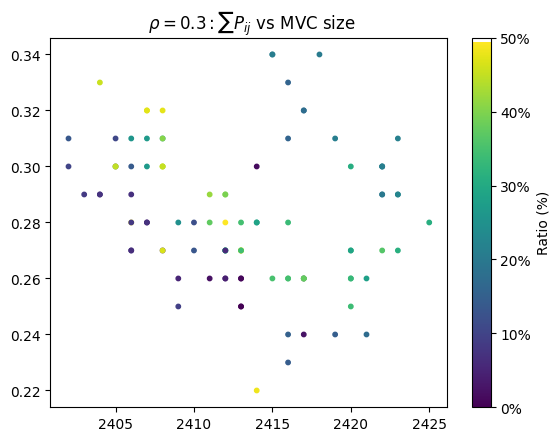

In [13]:
n_exp = 100
value = 0.3
rhos = np.full(n_exp, value)
ratios = np.random.uniform(0.0001, 0.5000, n_exp)
a = np.ones([DD1.shape[0]])/DD1.shape[0]
b = np.ones([DD2.shape[0]])/DD2.shape[0]
sot_options = {'penalty': 10, 'niter_sOT': 50000, 'f_init': np.zeros_like(a), 'g_init': np.zeros_like(b)}
A_sum_list = []
P_sum_list = []
Ratio_list = []

for i in range(n_exp):
    A, test = get_cover(DD1, DD2, threshold=rhos[i], ratio=ratios[i])
    if test == 0:
        print("error")
        break
        
    if test == 1:
        C = np.ones_like(A)
        C[np.where(A>0)] = np.inf
        P,_,_ = perform_sOT_log(C, a, b, 0.01, sot_options)
        print(i, int(A.sum()), P.sum(), ratios[i])
        A_sum_list.append(int(A.sum()))
        P_sum_list.append(P.sum())
        Ratio_list.append(ratios[i])
    
np.save('DiskDisk_A_sum_rho_0.3_0107.npy', A_sum_list)
np.save('DiskDisk_P_sum_rho_0.3_0107.npy', P_sum_list)
np.save('DiskDisk_Ratio_rho_0.3_0107.npy', Ratio_list)

scatter = plt.scatter(A_sum_list, P_sum_list, s=10, c=ratios)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio (%)')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
plt.title(r' $\rho=0.3 : \sum P_{ij}$ vs MVC size')
plt.savefig('DiskDisk_MVC_rho_0.3_0107.png')


In [ ]:
# rho=0.2

0 2445 0.21000000000000554 0.20856930015081673
1 2446 0.19000000000000694 0.3601902142717348
2 2448 0.1700000000000058 0.00015717597119070884
3 2445 0.2000000000000073 0.1512360530586567
4 2446 0.19000000000000594 0.07346326981947482
5 2447 0.1900000000000059 0.04626006352492203
6 2443 0.22000000000000772 0.09321147966769769
7 2445 0.21000000000000615 0.17284580744881956
8 2443 0.23000000000000698 0.1984440603679119
9 2438 0.24000000000000737 0.26945448532827815
10 2444 0.22000000000000855 0.20965533775020706
11 2445 0.20000000000000878 0.3426412282483401
12 2443 0.22000000000000772 0.10230567964078557
13 2446 0.19000000000000516 0.4390709064518336
14 2444 0.21000000000000676 0.01379105783964329
15 2447 0.19000000000000633 0.3352667083381833
16 2445 0.21000000000000554 0.20871067070332677
17 2437 0.24000000000000637 0.2793890452400313
18 2445 0.1900000000000059 0.07027943060375737
19 2443 0.22000000000000813 0.0991309343935309
20 2449 0.1900000000000049 0.4003922098809008
21 2445 0.210

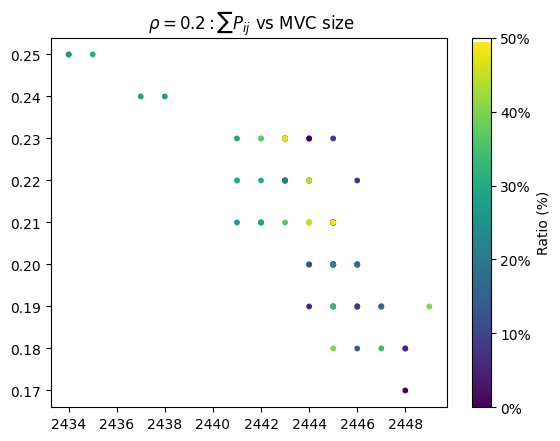

In [14]:
n_exp = 100
value = 0.2
rhos = np.full(n_exp, value)
ratios = np.random.uniform(0.0001, 0.5000, n_exp)
a = np.ones([DD1.shape[0]])/DD1.shape[0]
b = np.ones([DD2.shape[0]])/DD2.shape[0]
sot_options = {'penalty': 10, 'niter_sOT': 50000, 'f_init': np.zeros_like(a), 'g_init': np.zeros_like(b)}
A_sum_list = []
P_sum_list = []
Ratio_list = []

for i in range(n_exp):
    A, test = get_cover(DD1, DD2, threshold=rhos[i], ratio=ratios[i])
    if test == 0:
        print("error")
        break
        
    if test == 1:
        C = np.ones_like(A)
        C[np.where(A>0)] = np.inf
        P,_,_ = perform_sOT_log(C, a, b, 0.01, sot_options)
        print(i, int(A.sum()), P.sum(), ratios[i])
        A_sum_list.append(int(A.sum()))
        P_sum_list.append(P.sum())
        Ratio_list.append(ratios[i])
    
np.save('DiskDisk_A_sum_rho_0.2_0107.npy', A_sum_list)
np.save('DiskDisk_P_sum_rho_0.2_0107.npy', P_sum_list)
np.save('DiskDisk_Ratio_rho_0.2_0107.npy', Ratio_list)

scatter = plt.scatter(A_sum_list, P_sum_list, s=10, c=ratios)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio (%)')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
plt.title(r' $\rho=0.2 : \sum P_{ij}$ vs MVC size')
plt.savefig('DiskDisk_MVC_rho_0.2_0107.png')
